# Исследование продаж приложения Procrastinate Pro+

В последние несколько месяцев компания терпит убытки несмотря на значительные вложения в рекламу.
Необходимо выявить причины и предоставить вывод о проведенном анализе.
В нашем распоряжении данные о пользователях, привлеченных с 1 мая 27 октября 2019 года.

**Цели исследования:**
- определить откуда приходят пользователи и какими устройствами они пользуются
- проанализировать сколько стоит привлечение пользователей из различных рекламных каналов
- узнать сколько денег приносит каждый клиент
- построить графики и проверить, когда расходы на привлечение клиента окупаются
- сделать вывода о том, какие факторы мешают привлечению клиентов

**Данные:**

Данные для исследования будут получены из следующих файлов:
- визиты: /datasets/visits_info_short.csv
- заказы: /datasets/orders_info_short.csv
- расходы: /datasets/costs_info_short.csv

В первую очередь необходимо будет провести предобработку данных, а именно проверить данные на наличие пропусков и дубликатов.
Далее необходимо проверить типы данных, при необходимости заменить названия столбцов. Особенное внимание стоит уделить значениям с датой и временем.

**Описание данных:**

`visits_info_short.csv`:
- User Id — уникальный идентификатор пользователя
- Region — страна пользователя
- Device — тип устройства пользователя
- Channel — идентификатор источника перехода
- Session Start — дата и время начала сессии
- Session End — дата и время окончания сессии

`orders_info_short.csv`:
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

`costs_info_short.csv`:
- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.

**Ход исследования:**

1. Загрузка данных и подготовка к исследованию
2. Написани функции для расчёта и анализа LTV, ROI, удержания и конверсии
3. Исследовательский анализ данных
4. Маркетинг
5. Оценка окупаемости рекламы
6. Вывод

## Загрузка данных и подготовка к исследованию

### Импорт библиотек и чтение файлов

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
display(visits.head(), orders.head(), costs.head())

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


### Изменение названий столбцов

Приведем в порядок названия колонок в датасетах, для удобства создадим функцию, которая приведет названия к lower_case, а затем к snake_case

In [4]:
datasets = [visits, orders, costs]

In [5]:
def snakecase(df):
    df.columns = df.columns.str.lower().str.replace(' ','_')
    
for i in datasets:
    snakecase(i)

### Просмотр информации о типах значений, пропусках и дубликатах

Создадим функцию для просмотра информации, доли пропусков и количества дубликатов в датасете:

In [6]:
def first_look(df):
    print(df.info())
    print("""
        Доля пропущенных значений
    """)
    print(df.isna().sum() / len(df))
    print("""
        Количество дубликатов
    """)
    print(df.duplicated().sum())

In [7]:
first_look(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None

        Доля пропущенных значений
    
user_id          0.0
region           0.0
device           0.0
channel          0.0
session_start    0.0
session_end      0.0
dtype: float64

        Количество дубликатов
    
0


In [8]:
first_look(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None

        Доля пропущенных значений
    
user_id     0.0
event_dt    0.0
revenue     0.0
dtype: float64

        Количество дубликатов
    
0


In [9]:
first_look(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None

        Доля пропущенных значений
    
dt         0.0
channel    0.0
costs      0.0
dtype: float64

        Количество дубликатов
    
0


Как видно, пропущенных значений и дубликатов во всех датасетах нет. Необходимо поменять тип данных в столбцах `session_start` и `session_end` в датасете `visits` , `event_dt` в датасете `orders` и в столбце `dt` в `costs`

### Изменение типов данных и их проверка

In [10]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

Проверим максимальные и минимальные даты в датасетах

In [11]:
print(visits['session_start'].min())
print(visits['session_start'].max())

2019-05-01 00:00:41
2019-10-31 23:59:23


In [12]:
print(visits['session_end'].min())
print(visits['session_end'].max())

2019-05-01 00:07:06
2019-11-01 01:38:46


In [13]:
print(orders['event_dt'].min())
print(orders['event_dt'].max())

2019-05-01 00:28:11
2019-10-31 23:56:56


In [14]:
print(costs['dt'].min())
print(costs['dt'].max())

2019-05-01 00:00:00
2019-10-27 00:00:00


Посмотрим на уникальные категориальные значения в датасетах 

In [15]:
print(visits['region'].unique())
print(visits['device'].unique())
print(visits['channel'].unique())

['United States' 'UK' 'France' 'Germany']
['iPhone' 'Mac' 'Android' 'PC']
['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']


In [16]:
print(costs['channel'].unique())


['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'
 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'
 'lambdaMediaAds']


### Вывод

- Перед нами 2 датасета с данными о визитах пользователях сервиса, которые включают данные о регионе, типе устройства и канале привлечения; о дате, времени и сумме заказа пользователя; а так же данные о каналах привлечения и информацие о дате и смоимости
- В результате первичного обзора и предобработки было выявлено отсутсвие дубликатов и пропусков. Заменены типы данных, где это было необходимо, а так же были проведены проверки соответсвия дат в датасетах.

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии

В исследовании будем применять когортный анализ. Необходимо проанализировать следующие метрики:
- Retention Rate
- Convertion Rate
- LTV
- ROI

Для решения этой задачи зададим функции, которые в последствии упростят работу с данными

### Профили пользователей

In [17]:
def get_profiles(sessions, orders, ad_costs):

    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].dt.date.astype('datetime64[ns]')
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    return profiles

### Функция для подсчёта Retention Rate

In [18]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для подсчёта конверсии

In [19]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

### Функция для подсчета LTV и ROI

In [20]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes

        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функция для сглаживания данных

In [21]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

### Функция для построения графика Retention Rate

In [22]:
def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))

    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

### Функция для построения графика конверсии

In [23]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Функция для визуализации LTV и ROI

In [24]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    cac_history = roi_history[['cac']]

    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

### Профили пользователей

Составим профили пользователей и определим самую раннюю и позднюю даты привлечения.

In [25]:
profiles = get_profiles(visits, orders, costs)

In [26]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [27]:
print('Самая ранняя дата:', profiles['dt'].min())
print('Самая поздняя дата:', profiles['dt'].max())

Самая ранняя дата: 2019-05-01 00:00:00
Самая поздняя дата: 2019-10-27 00:00:00


In [28]:
profiles['user_id'].nunique()

150008

С помощью функции `get_profiles` мы вывели профили 150008 пользователей, с информацией о:
- дате и времени привлечения
- канале
- устройстве с которого пользователь заходил на сервис
- регионепользователя
- месяце привлечения
- категории пользователя (платящего или нет)
- Customer Acquisition Cost каждого пользователя

CAC некоторых пользователей равен 0, что вполне логично потому, что канал их привлечения - organic, что говорит нам о том, что на привлечение этих пользователей мы не тратили средства для запки траффика

Самые ранние и поздние даты соответствуют ожиданиям.

### Анализ по странам

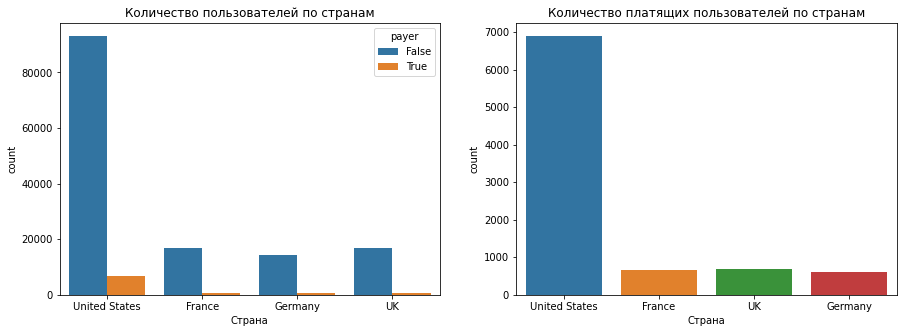

In [29]:
plt.figure(figsize=(15,5))
sns.countplot(data=profiles, x='region', hue='payer', ax=plt.subplot(1, 2, 1))
plt.title('Количество пользователей по странам')
plt.xlabel('Страна')

sns.countplot(data=profiles.query('payer == True'), x='region', ax=plt.subplot(1, 2, 2))
plt.title('Количество платящих пользователей по странам')
plt.xlabel('Страна');

In [30]:
users_by_region = profiles.groupby('region', as_index=False)[['user_id']].count()
users_by_region = users_by_region.rename(columns={'user_id': 'all_of_users'})
payed_users_by_region = profiles.query('payer == True').groupby('region', as_index=False)[['user_id']].count()

In [31]:
region_table = users_by_region.merge(payed_users_by_region, on='region')
region_table['perc'] = region_table['user_id'] / region_table['all_of_users'] * 100
region_table = region_table.drop(columns='user_id')

In [32]:
region_table

,region,all_of_users,perc
0,France,17450,3.799427
1,Germany,14981,4.111875
2,UK,17575,3.982930
3,United States,100002,6.901862


Из графиков видно, что пользователи в приложение приходят в основном из **США**. Такая же ситуация и с платащими пользователями. Построив таблицу отношения платящих к общему числу пользователей видно, что наибольшая доля так же в **США**, а наименьшая во **Франции**. Общие конверсии в этих странах равны **6.9%** и **3.8%** соответственно.

### Анализ по устройствам

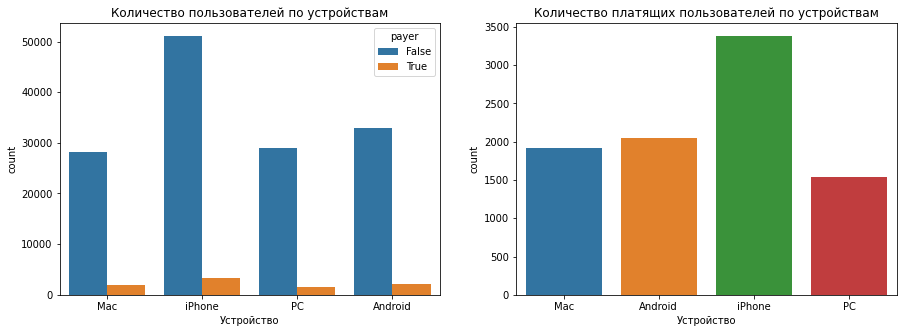

In [33]:
plt.figure(figsize=(15,5))
sns.countplot(data=profiles, x='device', hue='payer', ax=plt.subplot(1, 2, 1))
plt.title('Количество пользователей по устройствам')
plt.xlabel('Устройство')

sns.countplot(data=profiles.query('payer == True'), x='device', ax=plt.subplot(1, 2, 2))
plt.title('Количество платящих пользователей по устройствам')
plt.xlabel('Устройство');

In [34]:
users_by_device = profiles.groupby('device', as_index=False)[['user_id']].count()
users_by_device = users_by_device.rename(columns={'user_id': 'all_of_users'})
payed_users_by_device = profiles.query('payer == True').groupby('device', as_index=False)[['user_id']].count()

In [35]:
device_table = users_by_device.merge(payed_users_by_device, on='device')
device_table['perc'] = device_table['user_id'] / device_table['all_of_users'] * 100
device_table = device_table.drop(columns='user_id')

In [36]:
device_table

,device,all_of_users,perc
0,Android,35032,5.851793
1,Mac,30042,6.364423
2,PC,30455,5.046790
3,iPhone,54479,6.207897


Из графиков видно, что больше всего платящих пользователей пользуется **iPhone**. Из таблицы видно, что наибольшие доли платящих пользователей относительно общего количества пользователе у Mac и iPhone с долями **6.36%** и **6.12%** соответственно

### Анализ рекламных источников

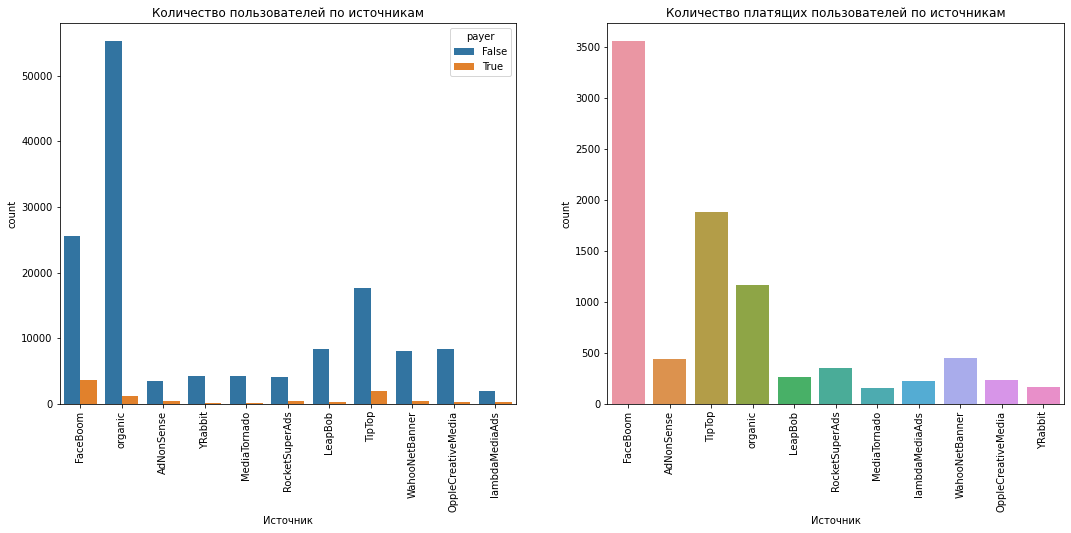

In [37]:
plt.figure(figsize=(18,7))
sns.countplot(data=profiles, x='channel', hue='payer', ax=plt.subplot(1, 2, 1))
plt.title('Количество пользователей по источникам')
plt.xlabel('Источник')
plt.xticks(rotation = 90)

sns.countplot(data=profiles.query('payer == True'), x='channel', ax=plt.subplot(1, 2, 2))
plt.title('Количество платящих пользователей по источникам')
plt.xlabel('Источник')
plt.xticks(rotation = 90);

In [38]:
users_by_channel = profiles.groupby('channel', as_index=False)[['user_id']].count()
users_by_channel = users_by_channel.rename(columns={'user_id': 'all_of_users'})
payed_users_by_channel = profiles.query('payer == True').groupby('channel', as_index=False)[['user_id']].count()

In [39]:
channel_table = users_by_channel.merge(payed_users_by_channel, on='channel')
channel_table['perc'] = channel_table['user_id'] / channel_table['all_of_users'] * 100
channel_table = channel_table.drop(columns='user_id')

In [40]:
channel_table.sort_values(by='perc', ascending=False)

,channel,all_of_users,perc
1,FaceBoom,29144,12.204914
0,AdNonSense,3880,11.340206
9,lambdaMediaAds,2149,10.469986
6,TipTop,19561,9.600736
5,RocketSuperAds,4448,7.913669
7,WahooNetBanner,8553,5.296387
8,YRabbit,4312,3.826531
3,MediaTornado,4364,3.574702
2,LeapBob,8553,3.063253
4,OppleCreativeMedia,8605,2.707728


Из графиков и таблицы видно, что не учитывая пользователей пришедших самостоятельно, больше всего в приложении пользователей из источников **FaceBoom**	и **TipTop**. Доли плятящих пользователей наибольшие в осточниках **FaceBoom** и **AdNonSense** с долями **12.2%** и **11.3%** соответственно

## Маркетинг

### Общая сумма расходов на маркетинг

In [41]:
print('Общая сумма расходов равна', round(costs['costs'].sum(), 2))

Общая сумма расходов равна 105497.3


Общая суммра расходов за период с 1 мая по 27 октября 2019 года равна **105497.3**. На графике наблюдается тренд к увеличению вложений в маркетинг со временем

### Расходы на маркетинг по источникам

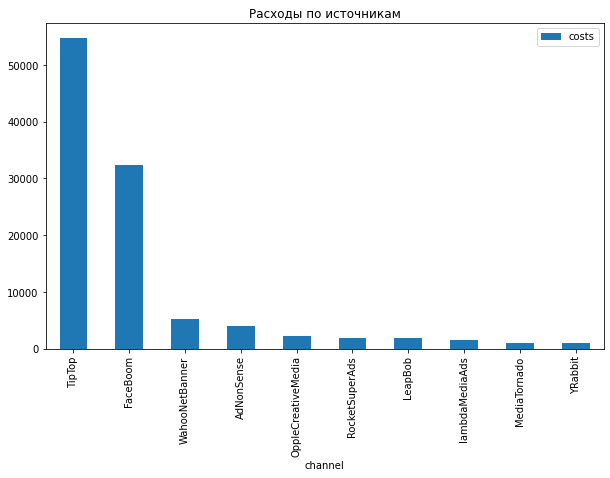

In [42]:
costs.groupby('channel')[['costs']].sum().sort_values(by='costs', ascending=False).plot(kind='bar', figsize=(10,6))
plt.title('Расходы по источникам');

In [43]:
costs.groupby('channel')[['costs']].sum().sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Наибольшие расходы у источников **TipTop** и **FaceBoom**

### Динамика расходов во времени

In [44]:
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month

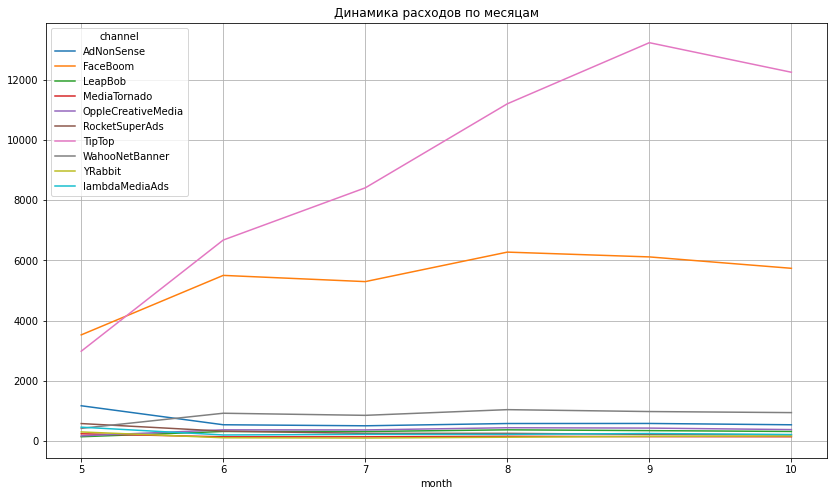

In [45]:
costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum').plot(figsize=(14,8), grid=True)
plt.title('Динамика расходов по месяцам');

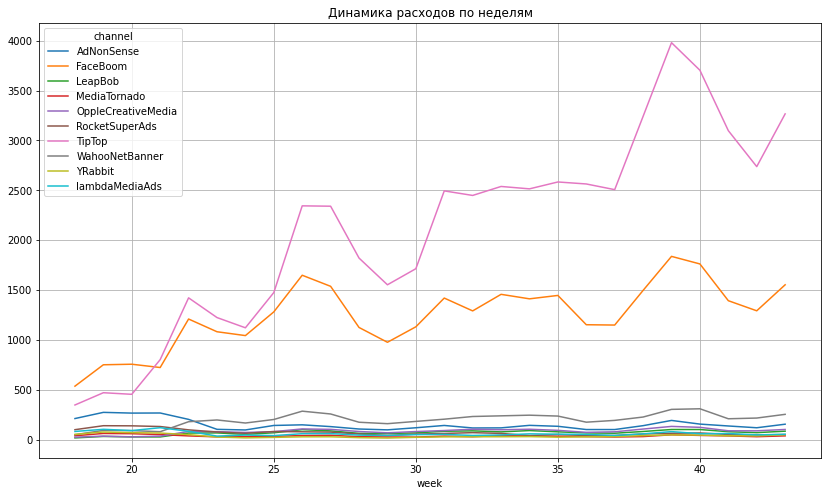

In [46]:
costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum').plot(figsize=(14,8), grid=True)
plt.title('Динамика расходов по неделям');

На графиков виден отрыв в расходах  на TipTop и FaceBoom. Наблюдается общая тенденция к увеличению расходов на маркетинг, а так же замедление темпов увеличения расходов начиная с сентября.

### Стоимость привлечения одного пользователя

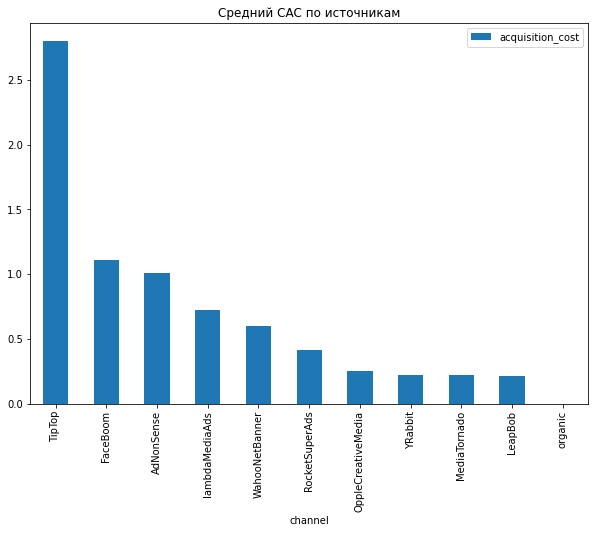

In [47]:
profiles.groupby('channel')[['acquisition_cost']].mean().sort_values(by='acquisition_cost', ascending=False)\
.plot(kind='bar', figsize=(10,7))
plt.title('Средний CAC по источникам');

In [48]:
profiles.groupby('channel')[['acquisition_cost']].mean().sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Наибольший средний CAC у пользователей пришедших из источников TipTop - **2.80**, FaceBoom - **1.11** и AdNonSense - **1.01**.
У источника organic CAC равняеется 0, так как мы не платили за это привлечение

## Оценка окупаемости рекламы

### Общая оценка окупаемости

Для анализа будет выбрана дата отсчета 1 ноября 2019 года, а лайфтайм 14 дней. Так же уберем из данных пользователей пришедших в приложение посредством органики.

In [49]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

In [50]:
profiles = profiles.query('channel != "organic"')

In [51]:
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False
)

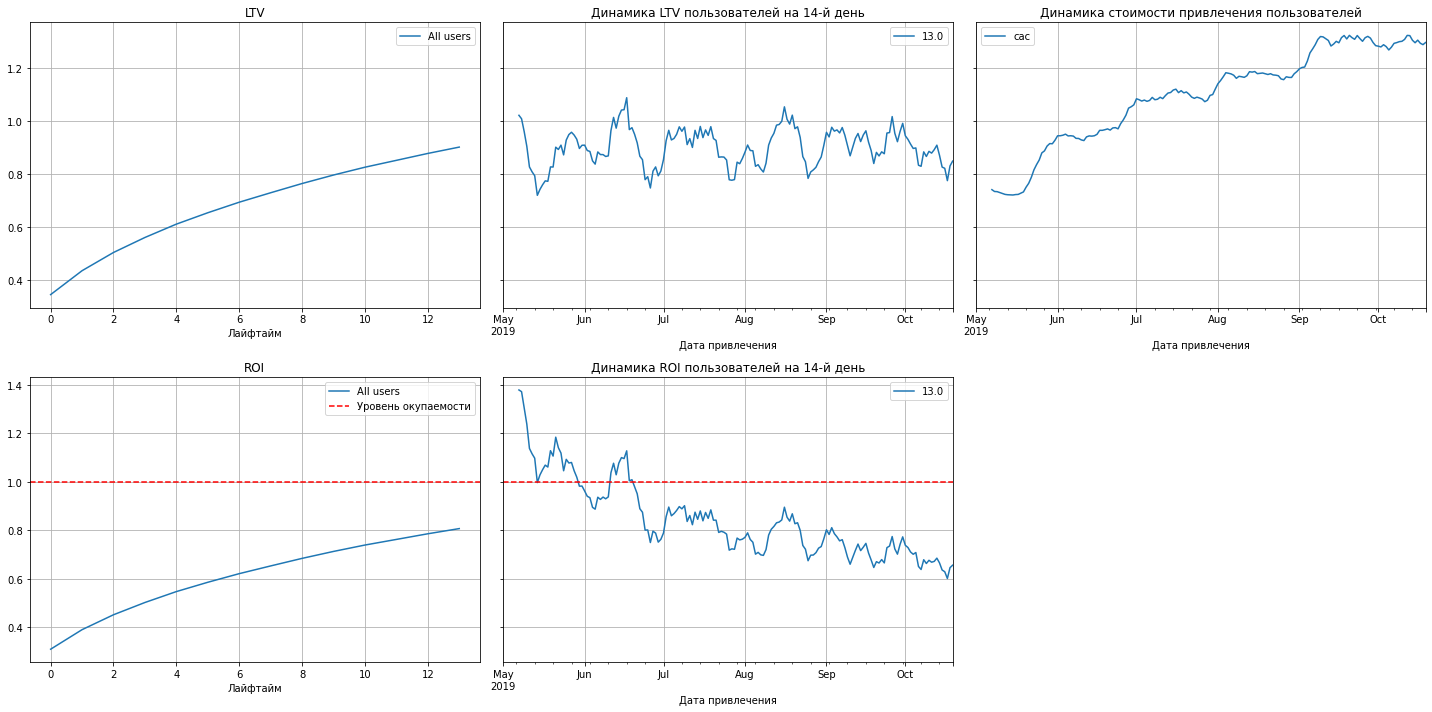

In [52]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days, window=7)

По графикам можно сделать следующие выводы:
- LTV на 14-й день приближается к значению **0.9**
- динамика LTV 14-го дня за период наблюдений не имеет выраженного тренда и остается в пределах от **0.7** до **1.1**
- CAC растет на протяжении всего наблюдения и начинает превышать значение **1** начиная с конца июня
- ROI к 14-му дню не доходит до уровня окупаемости, это говорит нам о том, что в целом реклама не окупается на данный момент
- динамика ROI 14-го дня показывается, что окупаться реклама перестала в середине июля

### Конверсия и удержание пользователей

При рассмотрении удержания пользователей, рассмотрим отдельно платящих и не платящих пользователей

In [53]:
conversion_raw, conversion_grouped, conversion_in_time = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False)

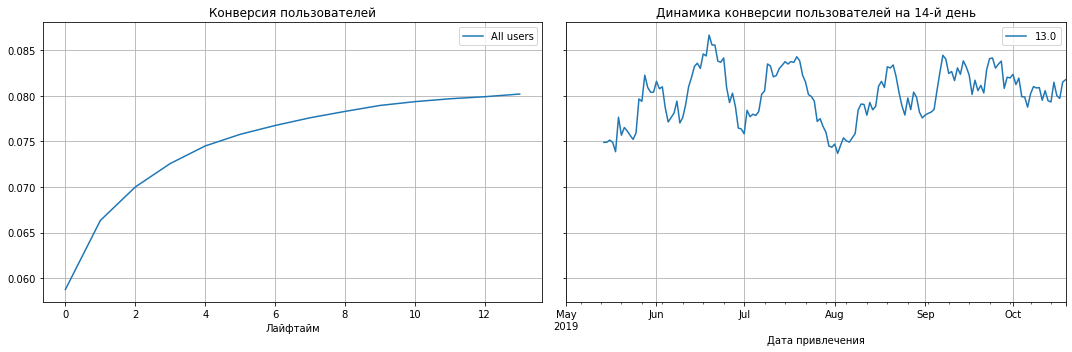

In [54]:
plot_conversion(conversion_grouped, conversion_in_time, horizon_days, window=14)

In [55]:
retention_raw, retention_grouped, retention_in_time = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False
)

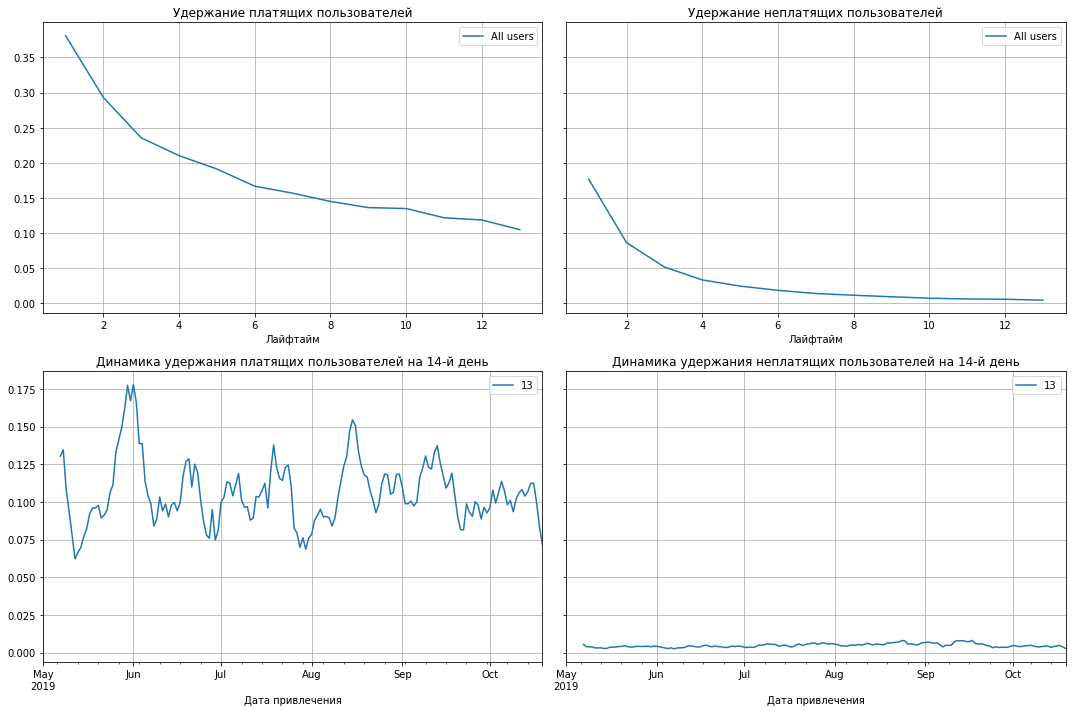

In [56]:
plot_retention(retention_grouped, retention_in_time, horizon_days, window=7)

Выводы по общей конверсии и удержании пользователей:
- на 14-й день конверсия достигает **8%**, а динамика 14-го дня показывает рост с **7.5%** до **8.2%**
- графики удержания платящих и не платащих пользователей показывает типичную картину в такого рода сервисе, на 14-й день мы сохраняем **10%** платящих, а неплатящих почти не остается
- динамика удержания 14-дня платящих пользователей остается в пределе **6-15%** без заметного тренда, так же дело обстоит и с не платящими - заметного тренда нет

### Окупасемость рекламы с разбивкой по уствойствам

In [57]:
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False
)

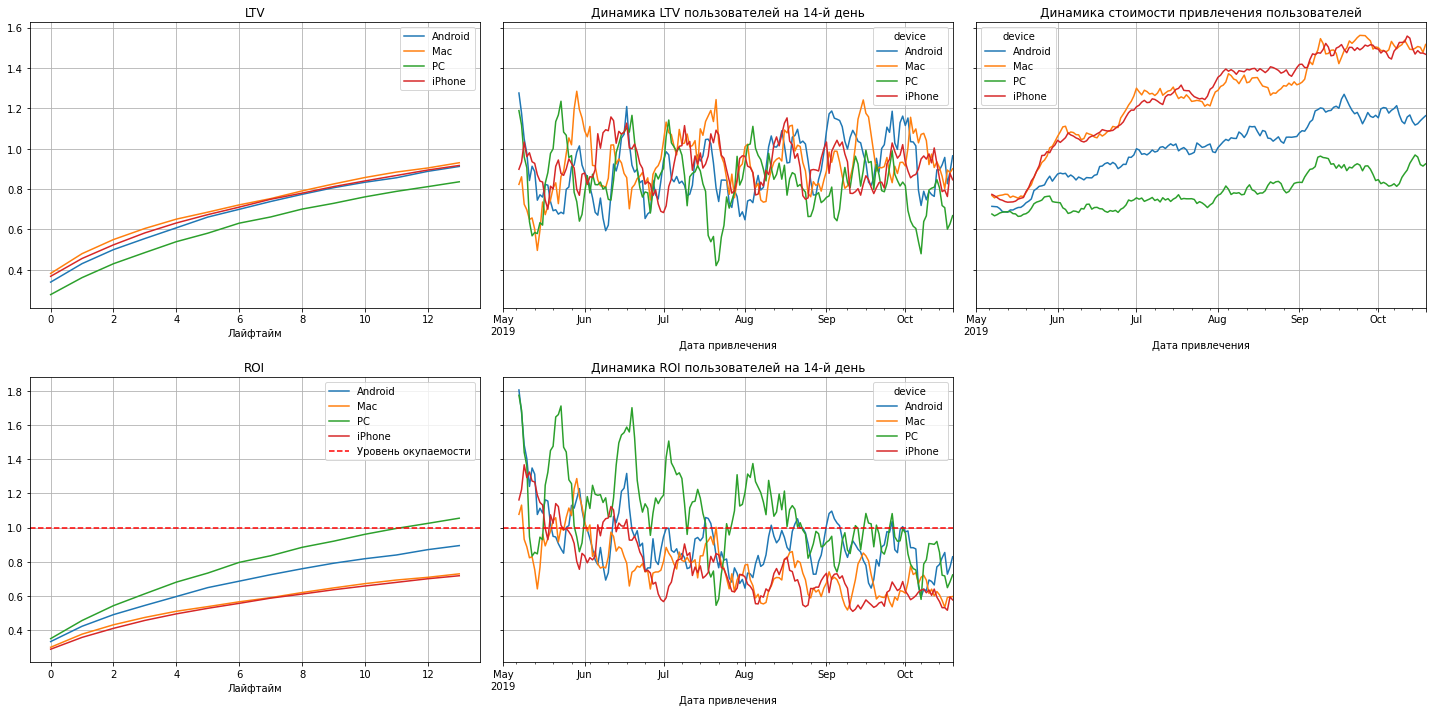

In [58]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days, window=7)

- LTV с 1-го по 14-й день платформы PC заметно ниже, на всем промежутке, относительно остальных платформ
- на графике динамики LTV 14-го дня так же заметно что показатели PC ниже, особенно в середине июля и в начале октября
- при этом CAC пользователей PC ниже всех и растет медленнее остальных, лидеры по росту CAC Mac и iPhone
- график ROI показывает нам, что пока реклама окупается на 14-й день только на платформе PC
- график динамики ROI 14-го дня показывает снижение рентабильности на всех платформах

### Окупасемость рекламы с разбивкой по странам

In [59]:
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False
)

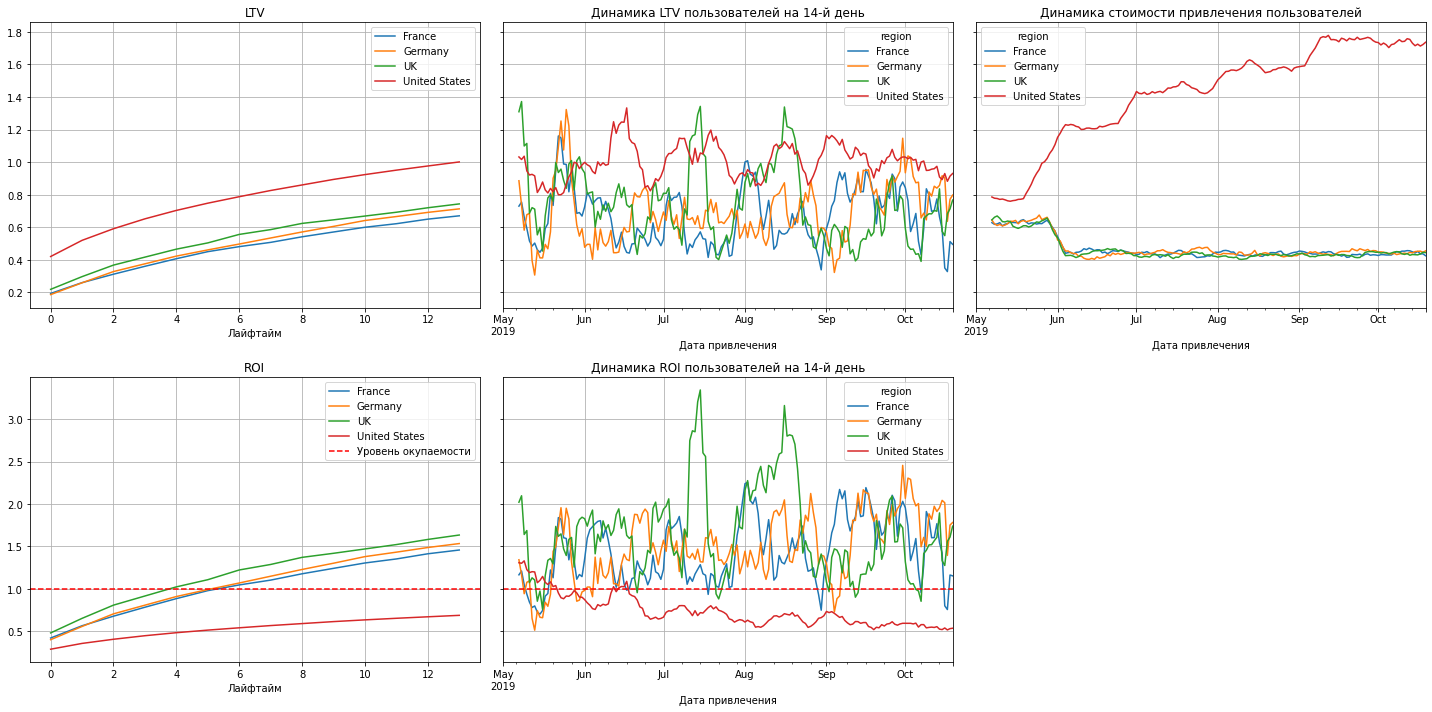

In [60]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days, window=7)

- LTV США заметно выше остальных стран
- динамика LTV 14-го дня не показывает заметных изменений в тренде
- начиная с середины мая CAC США резко вырос и продолжает расти, CAC Франции, Германии и Великобритании наоборот снизился, заметна очень большая разница в стоимости траффика между США и остальными странами
- все страны ктоме США - окупаются, что подтверждается динамикой

### Окупасемость рекламы с разбивкой по рекламным каналам

In [61]:
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False
)

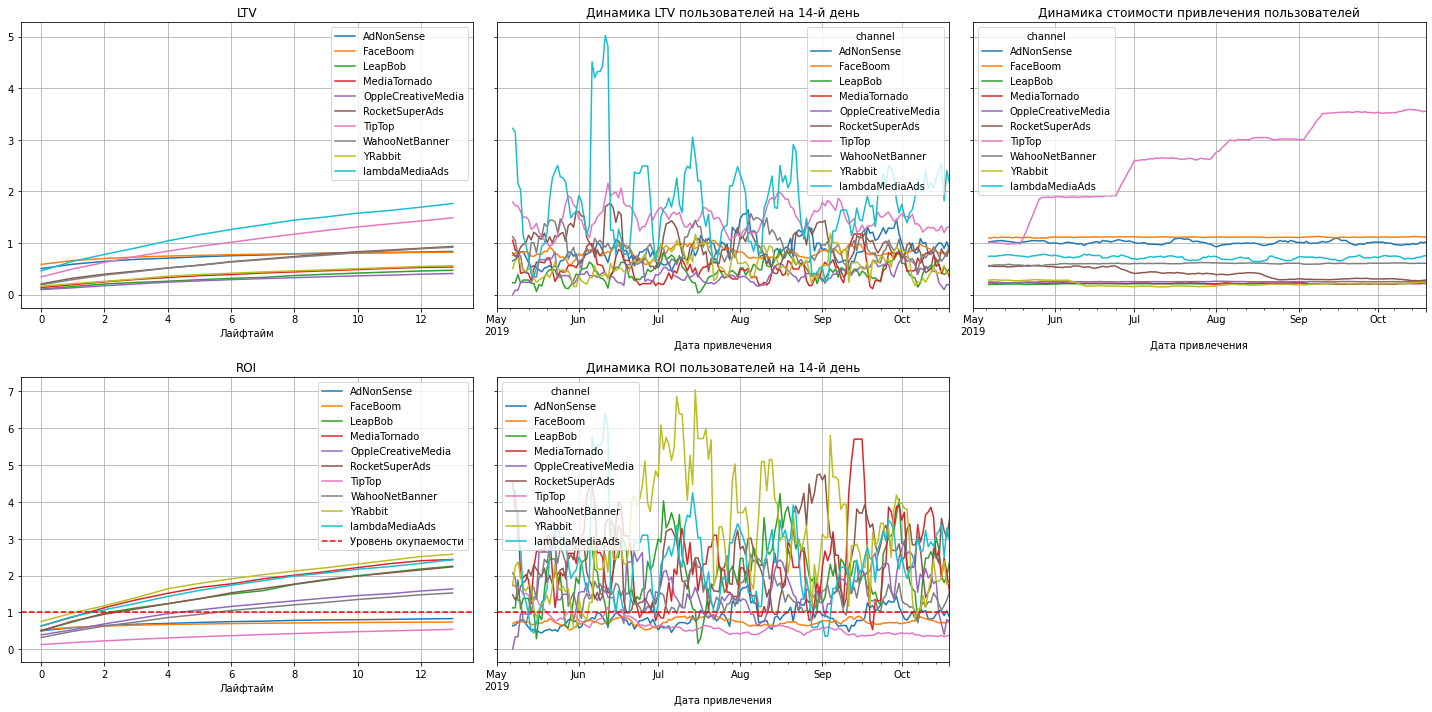

In [62]:
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days, window=7)

 - В целом на графиках видно, что наибольшие LTV нам приносят **LambdaMediaAds** и **Tip Top**, но в месте с этим CAC пользователей пришедших с канала **Tip Top** намного больше остальных что не позволяет этому канал выйти на рентабельность. Так же не выходят на рентабельность каналы FaceBoom и AdNonSense. Отдельно стоит отметить каналы **YRabbit**, **MediaTornado** и **lambdaMediaAds** показавшие наилучшую окупасемость среди остальных
 - Что касается двух других каналов не выходящих на рентабельность (FaceBoom и AdNonSense), назвать причину отсутствия окупаемости на первый взгляд сложно, для этого взглянем на них внимательнее и посмотрим на графики CR и Retention Rate с разбивкой по каналам

In [63]:
profiles_low_roi = get_profiles(visits, orders, costs)
profiles_low_roi = profiles_low_roi.query('channel == "AdNonSense" or channel == "FaceBoom"')

In [64]:
conversion_raw_low_roi, conversion_grouped_low_roi, conversion_in_time_low_roi = get_conversion(
    profiles_low_roi,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False)

In [65]:
conversion_raw_channel, conversion_grouped_channel, conversion_in_time_channel = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False)

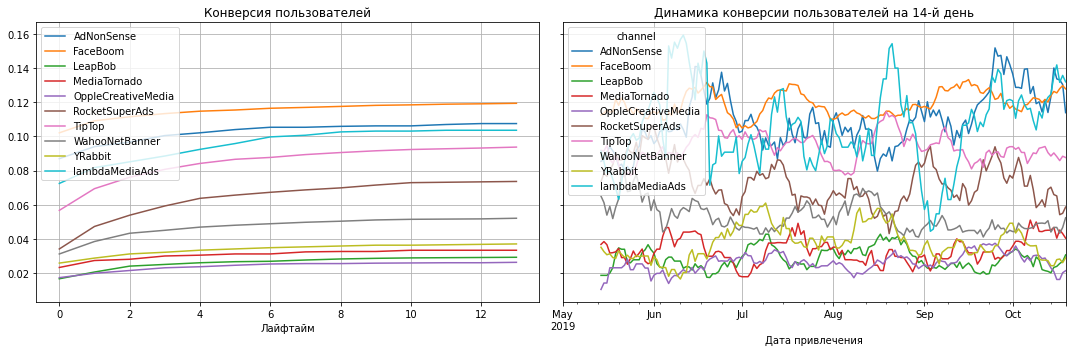

In [66]:
plot_conversion(conversion_grouped_channel, conversion_in_time_channel, horizon_days, window=14)

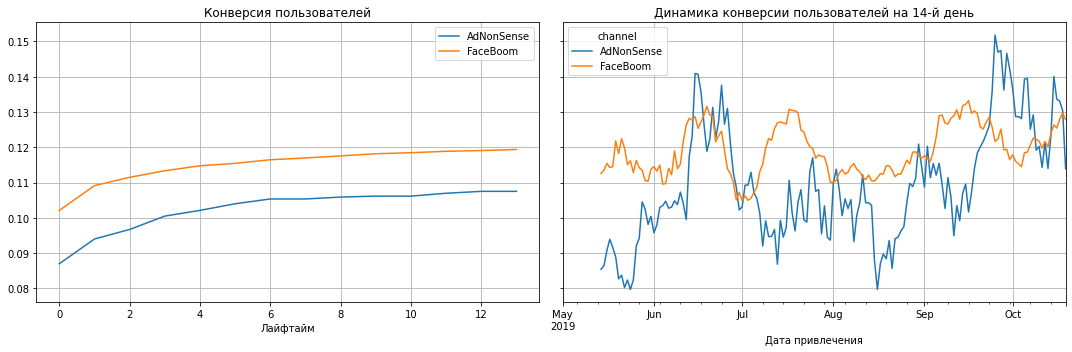

In [67]:
plot_conversion(conversion_grouped_low_roi, conversion_in_time_low_roi, horizon_days, window=14)

Видно, что у каналов FaseBoom и AdNonSense наилучшие показатели конверсии по отношению к остальным

In [68]:
retention_raw_low_roi, retention_grouped_low_roi, retention_in_time_low_roi = get_retention(
    profiles_low_roi,
    visits,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

In [69]:
retention_raw_channel, retention_grouped_channel, retention_in_time_channel = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False
)

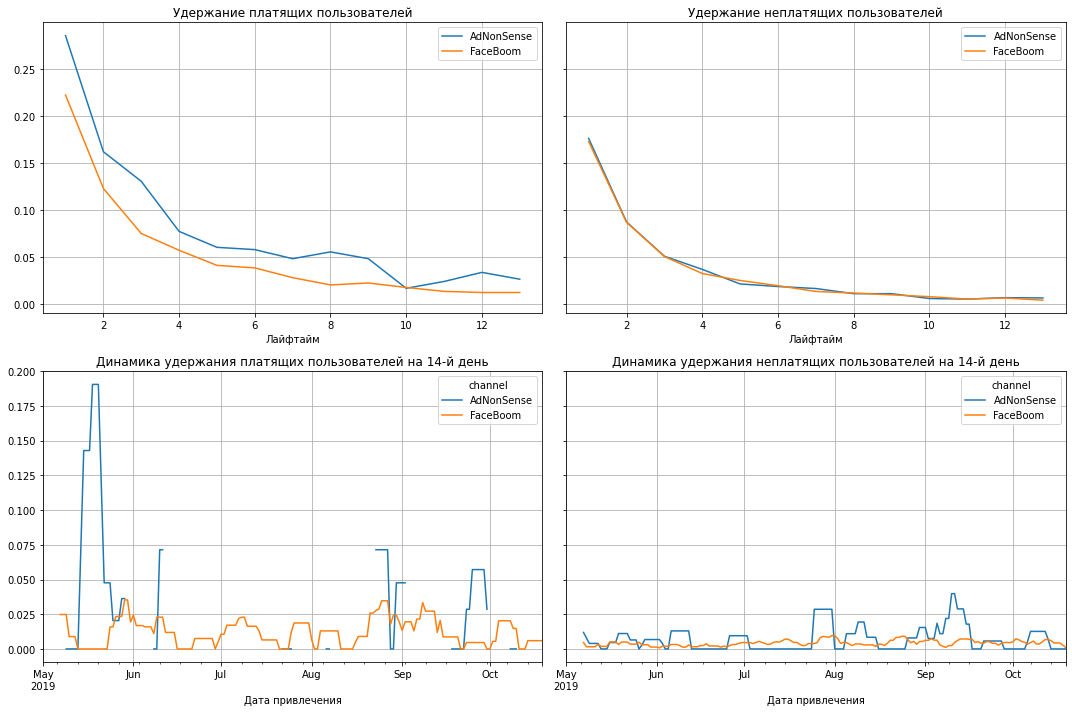

In [70]:
plot_retention(retention_grouped_low_roi, retention_in_time_low_roi, horizon_days, window=7)

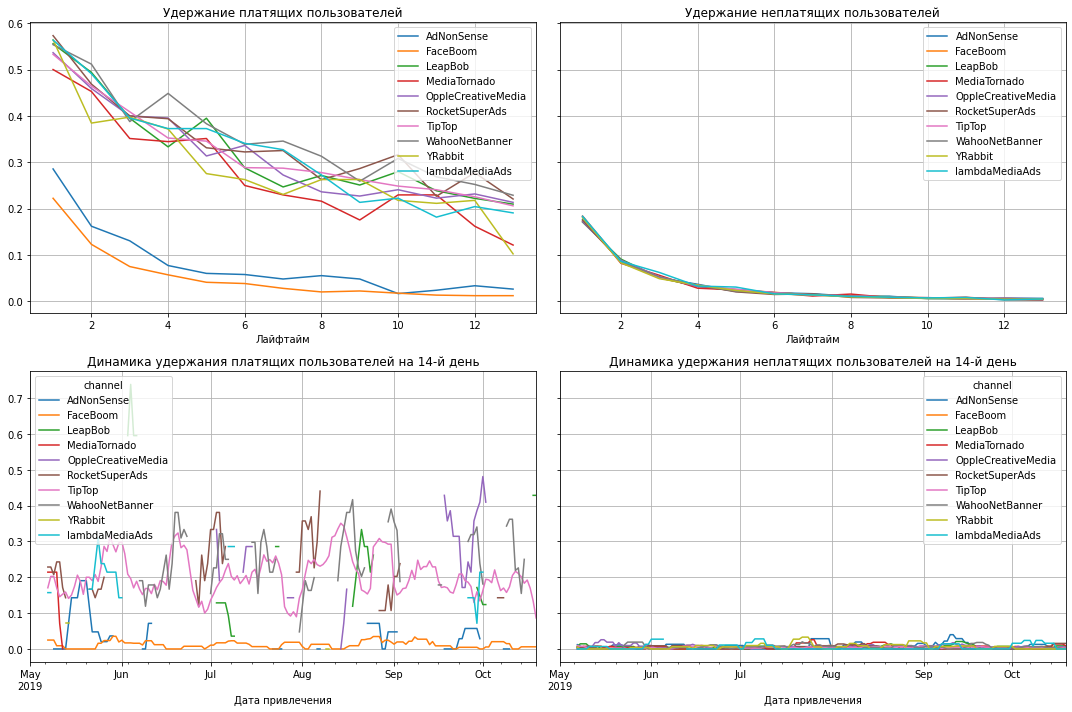

In [71]:
plot_retention(retention_grouped_channel, retention_in_time_channel, horizon_days, window=7)

А вот и доказательство неокупаемости этих каналов, на графике удержания платящих пользователей видно что показатели именно этих каналов сильно уступают остальным. Возможно с этих каналов приходят пользователи с рынков высокой конкуренции и в последствии раньше уходят в приложения конкуренты.

После анализа можно выделить следующие тезисы:
- устройства фирмы Apple не выходят на рентабельность по причине большой стоимости привлечения пользователя на этих устройствах
- привлечение пользователей из США так и не приносит прибыли, не смотря на подавляющее количество пользователей из этой страны, причинами являются очнь большая стоимость привлечения в этой стране и вероятно большая доля пользователей продукции Apple
- есть несколько ярко выраженнных проблемных каналов привлечения - Tip Top, в нем тек же очень дорогая стоимость привлечения одного пользователя, FaseBoom и AdNonSense, у них очень низкие показатели удержания платящих пользователей

### Окупасемость рекламы в США по каналам

In [72]:
profiles_usa = get_profiles(visits, orders, costs)
profiles_usa = profiles_usa.query('region == "United States" and channel != "organic"')

In [73]:
conversion_usa, conversion_grouped_usa, conversion_in_time_usa = get_conversion(
    profiles_usa,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False)

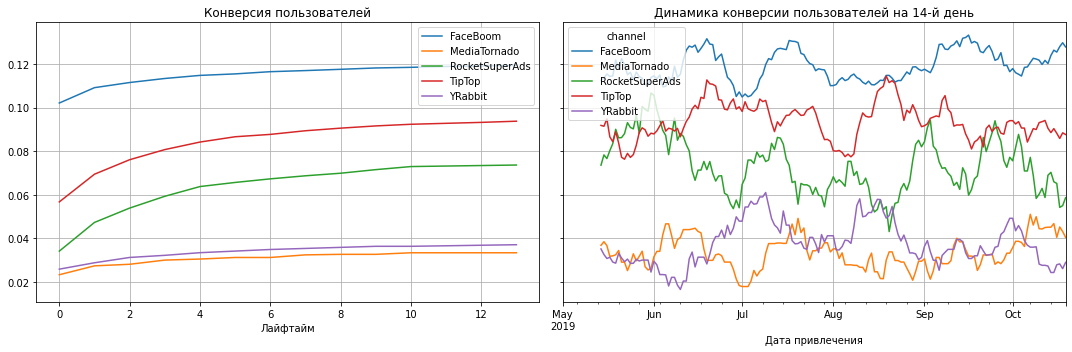

In [74]:
plot_conversion(conversion_grouped_usa, conversion_in_time_usa, horizon_days, window=14)

На графиках конверсии пользователей США видно, что лушие показатели у канала **FaseBoom**. Динамика 14-го дня в целом без без трендов, за исключением канала RocketSuperAds, этот канал имеет тренд к снижению показателей со временем

In [75]:
retention_usa, retention_grouped_usa, retention_in_time_usa = get_retention(
    profiles_usa,
    visits,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False
)

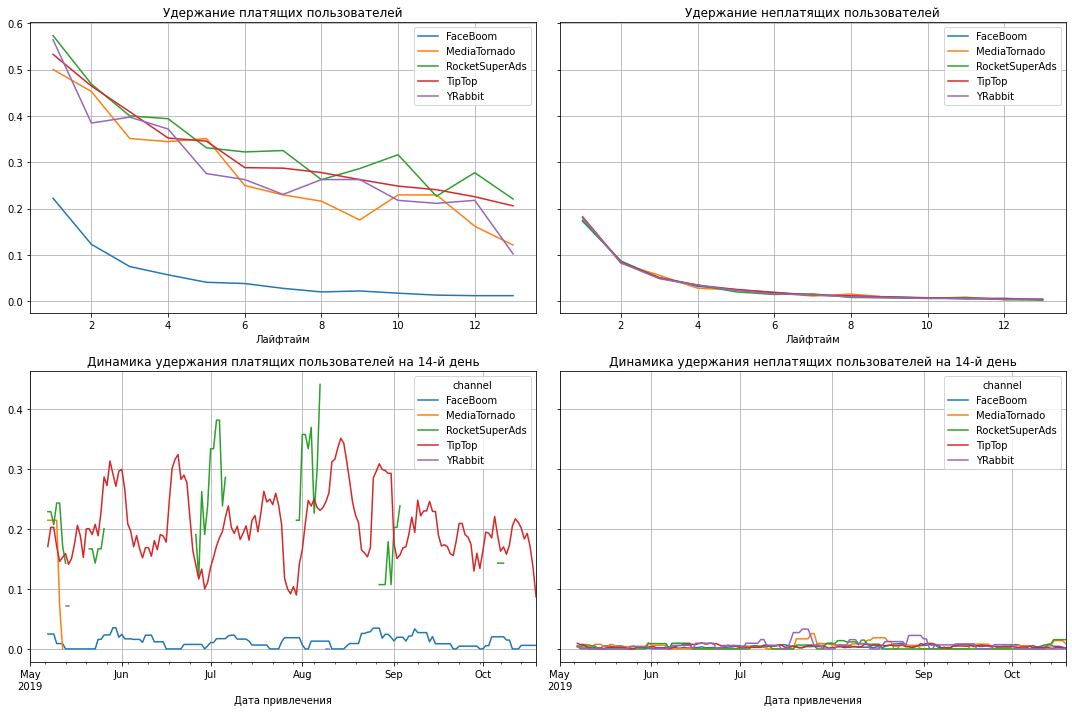

In [76]:
plot_retention(retention_grouped_usa, retention_in_time_usa, horizon_days, window=7)

Показатели удержания и динамики удержания платящих пользователей США канала FaceBoom заметно ниже остальных каналов. Это заставляет сделать предложение о пересмотре стратегии инвестирования в этот канала прежде всего в США

In [77]:
ltv_raw_usa, ltv_grouped_usa, ltv_in_time_usa, roi_grouped_usa, roi_in_time_usa = get_ltv(
    profiles_usa,
    orders,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False
)

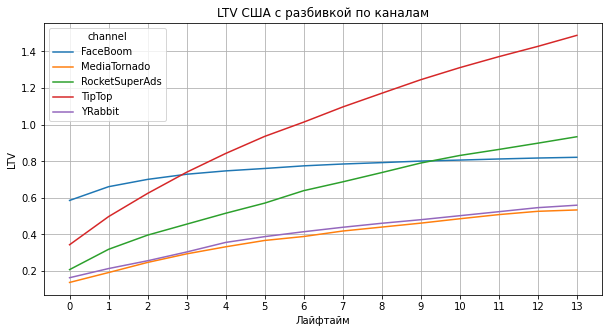

In [78]:
report = ltv_grouped_usa.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))
plt.title('LTV США с разбивкой по каналам')
plt.ylabel('LTV')
plt.xlabel('Лайфтайм')
plt.show()

На графике LTV США заметно, что показатели канала FaceBoom перестают расти начиная с 8-го дня, в отличии от остальных каналов, что говорит нам от том что после 8-го дня покупок с этого канала почти нет./

## Вывод

В данном проекте нами был осуществлен анализ показателей пользователей и маркетинга приложения Procrastinate Pro+. Чтобы ответить на поставленный вопрос о выявлении причин убытков компании, нами был проведен анализ ключевых метрик бизнеса (CR, Retention Rate, LTV, ROI, CAC) при помощи когортного анализа.

Ключевые тезисы:
- убытки компании подтверждаются отсутствием выхода на рентабельность маркетинговых инвестиций после 14-ти дней
- на окупаемость негативно оказывают устройства **iPhone** и **Mac**
- негативно сказывается канал привлечения пользователей **Tip Top** из-за сильного роста стоимости привлечения одного покупателя
- существут проблемы с рынком США, несмотря на то, что он превалирует в нашей деятельности, в целом макретинг в этой стране не окупается. По мимо высокой CAC **Tip Top**, негативное влияние оказывает канал **FaceBoom**, с низмкими показателями удержания платящих пользователей и почни полным отстутствием покупок после 8-го дня от привлечения.
- 

Рекомандации:
- пересмотреть рекламные планы рынца США в целом, поскольку рынок США и устройства без окупаемости связаны страной производителем
- проанализировать последствия и причины роста CAC Tip Top и пересмотреть политику привлечения через этот канал
- проанализировать канал FaceBoom в частности в США на предмет уменьшения инвестиций через этот канал в этой стране
- уделить большее внимание рынкам Франции Германии и Великобритании и перенаправить  маркетинговые инвестиции в эти страны